# Portfolio Rebalancing: Maintaining Your Target Allocation

## Learning Objectives

By the end of this notebook, you will understand:
- **Why portfolios drift** from their target allocations over time
- **Rebalancing strategies**: Calendar, threshold, and hybrid approaches
- **Trade-offs** between rebalancing frequency and transaction costs
- **Tax implications** of rebalancing in taxable accounts
- **How to implement** rebalancing logic in Python

---

## What is Portfolio Rebalancing?

**Rebalancing** is the process of realigning your portfolio weights back to their target allocations. As different assets perform differently, your actual weights **drift** from your intended allocation.

### Why Does Drift Happen?

Imagine you start with:
- 60% stocks (AAPL)
- 40% bonds (BND)

If stocks rise 20% and bonds rise 5%:
- Stocks: $60 → $72
- Bonds: $40 → $42
- New total: $114
- New weights: **63.2% stocks, 36.8% bonds**

Your portfolio has **drifted** from the original 60/40 allocation.

### Why Rebalance?

1. **Risk control**: Without rebalancing, winning assets dominate, increasing concentration risk
2. **Discipline**: Forces "buy low, sell high" behavior
3. **Alignment**: Keeps portfolio matched to your risk tolerance and goals
4. **Systematic**: Removes emotional decision-making

In [1]:
# Install required packages (uncomment if needed)
# !pip install yfinance pandas numpy matplotlib

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)
plt.style.use('seaborn-v0_8-whitegrid')

---

## Part 1: Understanding Weight Drift

Let's see how a portfolio drifts over time without rebalancing.

In [2]:
def simulate_drift(prices_df, initial_weights, initial_value=100000):
    """
    Simulate how portfolio weights drift over time without rebalancing.

    Parameters:
    -----------
    prices_df : DataFrame
        Price data for each asset
    initial_weights : dict
        Target weights for each asset {'AAPL': 0.6, 'BND': 0.4}
    initial_value : float
        Starting portfolio value

    Returns:
    --------
    weights_df : DataFrame
        Actual weights over time
    values_df : DataFrame
        Position values over time
    """
    # Calculate initial shares based on first day prices
    first_prices = prices_df.iloc[0]
    shares = {}

    for ticker, weight in initial_weights.items():
        allocation = initial_value * weight
        shares[ticker] = allocation / first_prices[ticker]

    # Calculate values and weights over time
    values_df = pd.DataFrame(index=prices_df.index)

    for ticker in initial_weights.keys():
        values_df[ticker] = shares[ticker] * prices_df[ticker]

    values_df['Total'] = values_df.sum(axis=1)

    # Calculate weights
    weights_df = values_df.drop('Total', axis=1).div(values_df['Total'], axis=0)

    return weights_df, values_df

# Download data for a simple two-asset portfolio
tickers = ['SPY', 'BND']  # S&P 500 ETF and Bond ETF
prices = yf.download(tickers, start='2020-01-01', end='2024-01-01', progress=False)['Close']

# Target allocation: 60% stocks, 40% bonds
target_weights = {'SPY': 0.60, 'BND': 0.40}

# Simulate drift
weights_df, values_df = simulate_drift(prices, target_weights)

print("Portfolio Drift Analysis (60/40 Stock/Bond Portfolio)")
print("=" * 55)
print(f"\nStarting weights: SPY={target_weights['SPY']:.0%}, BND={target_weights['BND']:.0%}")
print(f"Ending weights:   SPY={weights_df['SPY'].iloc[-1]:.1%}, BND={weights_df['BND'].iloc[-1]:.1%}")
print(f"\nSPY drift: {(weights_df['SPY'].iloc[-1] - target_weights['SPY'])*100:+.1f} percentage points")
print(f"BND drift: {(weights_df['BND'].iloc[-1] - target_weights['BND'])*100:+.1f} percentage points")

Portfolio Drift Analysis (60/40 Stock/Bond Portfolio)

Starting weights: SPY=60%, BND=40%
Ending weights:   SPY=70.7%, BND=29.3%

SPY drift: +10.7 percentage points
BND drift: -10.7 percentage points


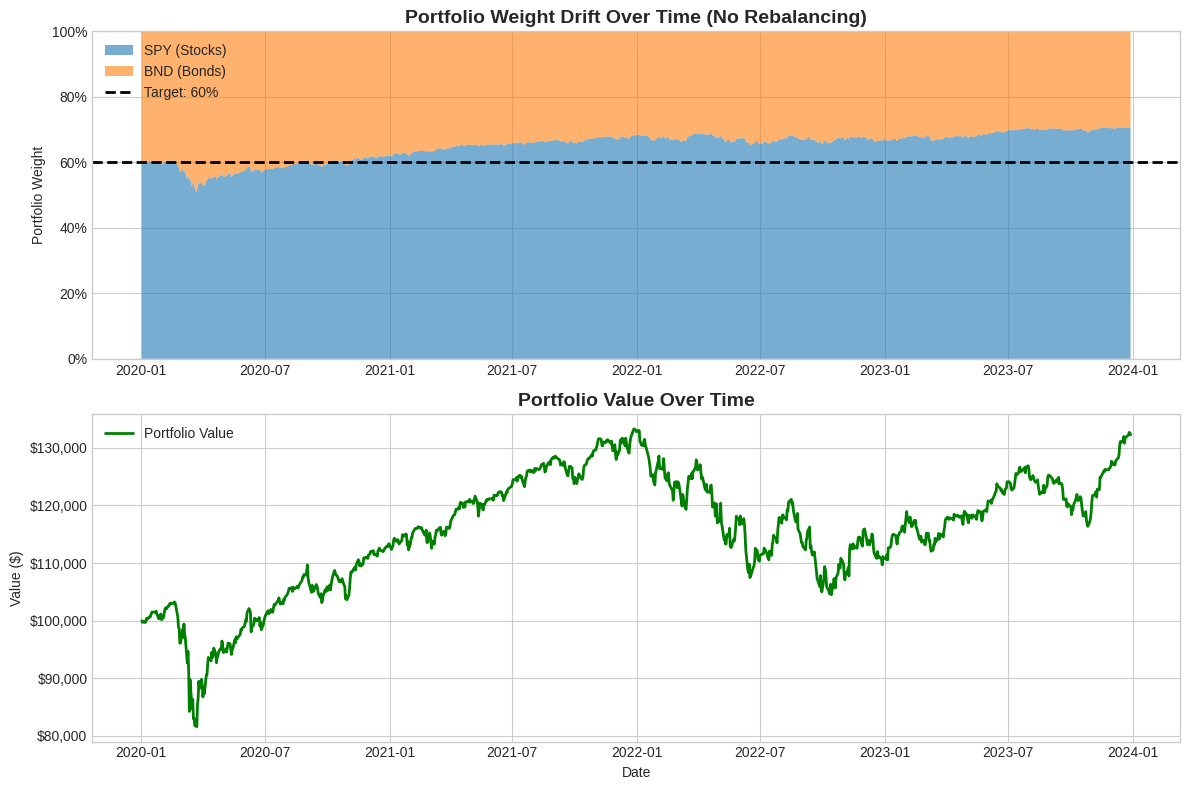


Weight Drift Statistics:
  Max SPY weight: 70.8%
  Min SPY weight: 50.8%
  Weight range:   20.0 percentage points


In [3]:
# Visualize the weight drift
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Weights over time
ax1 = axes[0]
ax1.fill_between(weights_df.index, 0, weights_df['SPY'], alpha=0.6, label='SPY (Stocks)')
ax1.fill_between(weights_df.index, weights_df['SPY'], 1, alpha=0.6, label='BND (Bonds)')
ax1.axhline(y=0.6, color='black', linestyle='--', linewidth=2, label='Target: 60%')
ax1.set_title('Portfolio Weight Drift Over Time (No Rebalancing)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Portfolio Weight')
ax1.set_ylim(0, 1)
ax1.legend(loc='upper left')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot 2: Value growth
ax2 = axes[1]
ax2.plot(values_df['Total'], linewidth=2, label='Portfolio Value', color='green')
ax2.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
ax2.set_ylabel('Value ($)')
ax2.set_xlabel('Date')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))
ax2.legend()

plt.tight_layout()
plt.show()

# Show drift statistics
print("\nWeight Drift Statistics:")
print(f"  Max SPY weight: {weights_df['SPY'].max():.1%}")
print(f"  Min SPY weight: {weights_df['SPY'].min():.1%}")
print(f"  Weight range:   {(weights_df['SPY'].max() - weights_df['SPY'].min())*100:.1f} percentage points")

---

## Part 2: Rebalancing Strategies

There are three main approaches to rebalancing:

### 1. Calendar Rebalancing
Rebalance at fixed time intervals (monthly, quarterly, annually).

**Pros:**
- Simple to implement
- Predictable transaction timing

**Cons:**
- May rebalance when not needed (small drift)
- May not catch large market moves between dates

### 2. Threshold Rebalancing
Rebalance when any asset drifts beyond a set threshold (e.g., ±5%).

**Pros:**
- Only trades when necessary
- Responds to market volatility

**Cons:**
- More monitoring required
- May trade frequently in volatile markets

### 3. Hybrid (Calendar + Threshold)
Check at fixed intervals, but only rebalance if threshold is breached.

**This is often the best approach** for most investors.

In [4]:
def calculate_rebalancing_trades(current_weights, target_weights, portfolio_value):
    """
    Calculate the trades needed to rebalance to target weights.

    Returns:
    --------
    trades : dict
        Dollar amounts to buy (positive) or sell (negative) for each asset
    """
    trades = {}

    for ticker in target_weights.keys():
        current_value = current_weights[ticker] * portfolio_value
        target_value = target_weights[ticker] * portfolio_value
        trades[ticker] = target_value - current_value

    return trades


def calendar_rebalance(prices_df, target_weights, frequency='Q', initial_value=100000):
    """
    Simulate calendar-based rebalancing.

    Parameters:
    -----------
    frequency : str
        'M' = Monthly, 'Q' = Quarterly, 'A' = Annually
    """
    # Get rebalancing dates based on frequency
    if frequency == 'M':
        rebal_dates = prices_df.resample('M').last().index
    elif frequency == 'Q':
        rebal_dates = prices_df.resample('Q').last().index
    else:  # Annual
        rebal_dates = prices_df.resample('A').last().index

    # Track portfolio over time
    shares = {}
    first_prices = prices_df.iloc[0]

    # Initial allocation
    for ticker, weight in target_weights.items():
        shares[ticker] = (initial_value * weight) / first_prices[ticker]

    # Track values and rebalancing events
    results = []
    rebalancing_events = []

    for date in prices_df.index:
        # Calculate current values
        current_prices = prices_df.loc[date]
        values = {ticker: shares[ticker] * current_prices[ticker] for ticker in shares}
        total_value = sum(values.values())
        weights = {ticker: values[ticker] / total_value for ticker in shares}

        results.append({
            'Date': date,
            'Total_Value': total_value,
            **{f'{t}_Weight': weights[t] for t in shares}
        })

        # Check if it's a rebalancing date
        if date in rebal_dates:
            # Calculate trades needed
            trades = calculate_rebalancing_trades(weights, target_weights, total_value)

            # Execute rebalancing
            for ticker in shares:
                shares[ticker] = (target_weights[ticker] * total_value) / current_prices[ticker]

            # Record event
            total_traded = sum(abs(t) for t in trades.values()) / 2  # Divide by 2 since buy = sell
            rebalancing_events.append({
                'Date': date,
                'Total_Value': total_value,
                'Amount_Traded': total_traded,
                **trades
            })

    results_df = pd.DataFrame(results).set_index('Date')
    events_df = pd.DataFrame(rebalancing_events) if rebalancing_events else pd.DataFrame()

    return results_df, events_df


# Run quarterly rebalancing simulation
quarterly_results, quarterly_events = calendar_rebalance(prices, target_weights, frequency='Q')

print("Calendar Rebalancing: Quarterly")
print("=" * 50)
print(f"Number of rebalancing events: {len(quarterly_events)}")
print(f"Total amount traded: ${quarterly_events['Amount_Traded'].sum():,.2f}")
print(f"Average trade size: ${quarterly_events['Amount_Traded'].mean():,.2f}")
print(f"\nFinal portfolio value: ${quarterly_results['Total_Value'].iloc[-1]:,.2f}")
print(f"Final weights: SPY={quarterly_results['SPY_Weight'].iloc[-1]:.1%}, BND={quarterly_results['BND_Weight'].iloc[-1]:.1%}")

Calendar Rebalancing: Quarterly
Number of rebalancing events: 13
Total amount traded: $31,089.03
Average trade size: $2,391.46

Final portfolio value: $131,358.44
Final weights: SPY=61.1%, BND=38.9%


In [7]:
def threshold_rebalance(prices_df, target_weights, threshold=0.05, initial_value=100000):
    """
    Simulate threshold-based rebalancing.

    Parameters:
    -----------
    threshold : float
        Rebalance when any weight drifts by more than this amount (e.g., 0.05 = 5%)
    """
    shares = {}
    first_prices = prices_df.iloc[0]

    # Initial allocation
    for ticker, weight in target_weights.items():
        shares[ticker] = (initial_value * weight) / first_prices[ticker]

    results = []
    rebalancing_events = []

    for date in prices_df.index:
        current_prices = prices_df.loc[date]
        values = {ticker: shares[ticker] * current_prices[ticker] for ticker in shares}
        total_value = sum(values.values())
        weights = {ticker: values[ticker] / total_value for ticker in shares}

        results.append({
            'Date': date,
            'Total_Value': total_value,
            **{f'{t}_Weight': weights[t] for t in shares}
        })

        # Check if threshold is breached
        max_drift = max(abs(weights[t] - target_weights[t]) for t in shares)

        if max_drift > threshold:
            trades = calculate_rebalancing_trades(weights, target_weights, total_value)

            for ticker in shares:
                shares[ticker] = (target_weights[ticker] * total_value) / current_prices[ticker]

            total_traded = sum(abs(t) for t in trades.values()) / 2
            rebalancing_events.append({
                'Date': date,
                'Total_Value': total_value,
                'Amount_Traded': total_traded,
                'Max_Drift': max_drift,
                **trades
            })

    results_df = pd.DataFrame(results).set_index('Date')
    events_df = pd.DataFrame(rebalancing_events) if rebalancing_events else pd.DataFrame()

    return results_df, events_df


# Run threshold rebalancing with 5% threshold
threshold_results, threshold_events = threshold_rebalance(prices, target_weights, threshold=0.05)

print("Threshold Rebalancing: 5% Drift Trigger")
print("=" * 50)
print(f"Number of rebalancing events: {len(threshold_events)}")
print(f"Total amount traded: ${threshold_events['Amount_Traded'].sum():,.2f}")
print(f"Average trade size: ${threshold_events['Amount_Traded'].mean():,.2f}")
print(f"\nFinal portfolio value: ${threshold_results['Total_Value'].iloc[-1]:,.2f}")

Threshold Rebalancing: 5% Drift Trigger
Number of rebalancing events: 4
Total amount traded: $22,843.78
Average trade size: $5,710.95

Final portfolio value: $131,808.67


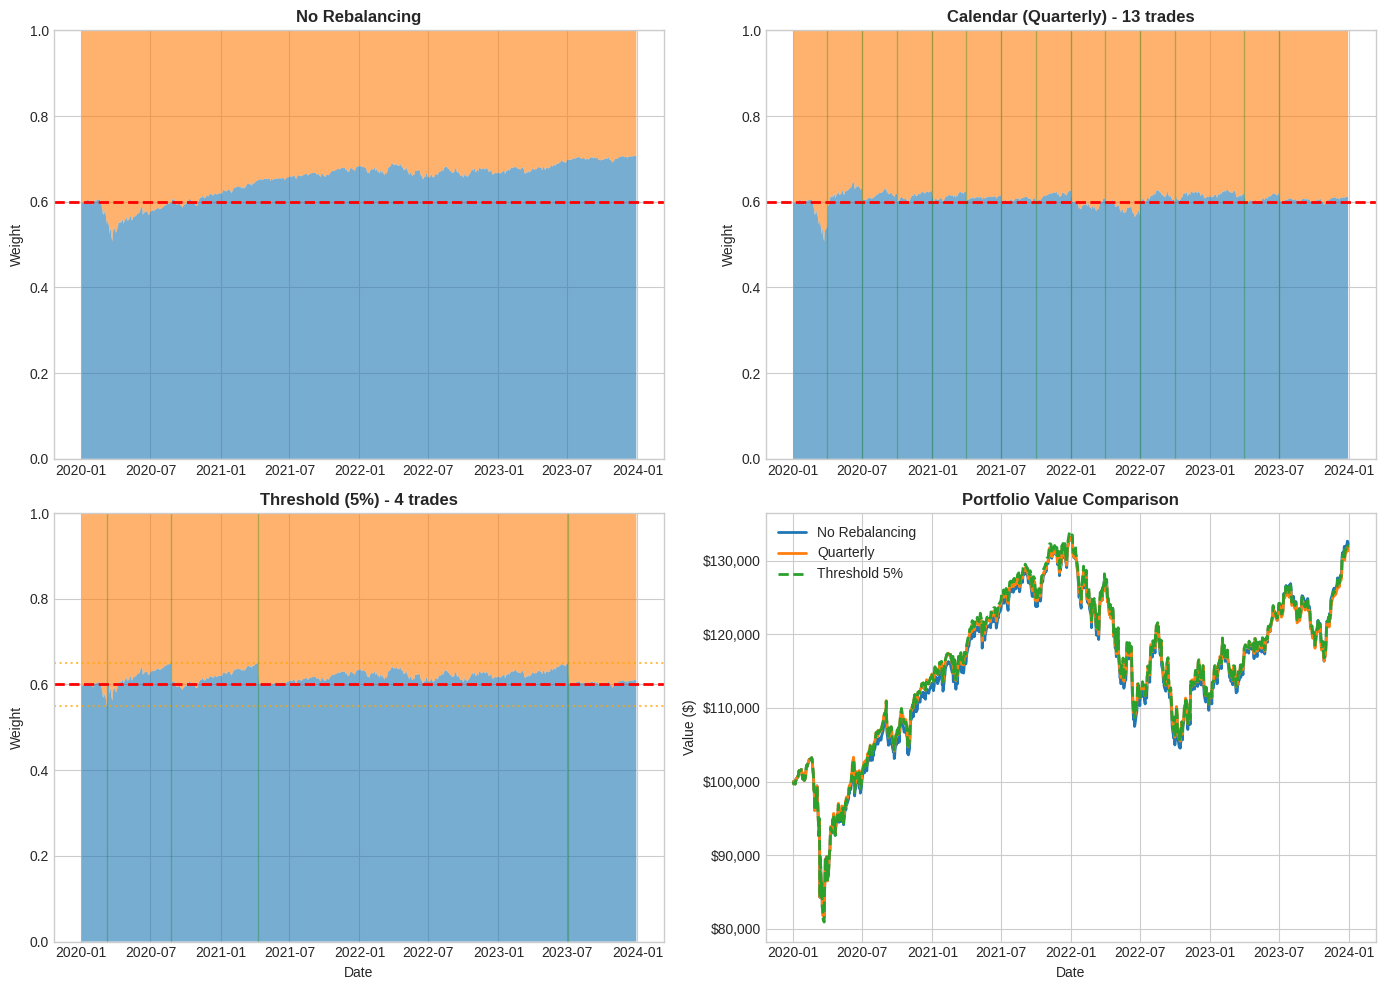

In [8]:
# Compare no rebalancing vs calendar vs threshold
no_rebal_results, no_rebal_values = simulate_drift(prices, target_weights)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: No rebalancing weights
ax1 = axes[0, 0]
ax1.fill_between(no_rebal_results.index, 0, no_rebal_results['SPY'], alpha=0.6, label='SPY')
ax1.fill_between(no_rebal_results.index, no_rebal_results['SPY'], 1, alpha=0.6, label='BND')
ax1.axhline(y=0.6, color='red', linestyle='--', linewidth=2)
ax1.set_title('No Rebalancing', fontsize=12, fontweight='bold')
ax1.set_ylabel('Weight')
ax1.set_ylim(0, 1)

# Plot 2: Calendar rebalancing weights
ax2 = axes[0, 1]
ax2.fill_between(quarterly_results.index, 0, quarterly_results['SPY_Weight'], alpha=0.6, label='SPY')
ax2.fill_between(quarterly_results.index, quarterly_results['SPY_Weight'], 1, alpha=0.6, label='BND')
ax2.axhline(y=0.6, color='red', linestyle='--', linewidth=2)
for date in quarterly_events['Date']:
    ax2.axvline(x=date, color='green', alpha=0.3, linewidth=1)
ax2.set_title(f'Calendar (Quarterly) - {len(quarterly_events)} trades', fontsize=12, fontweight='bold')
ax2.set_ylabel('Weight')
ax2.set_ylim(0, 1)

# Plot 3: Threshold rebalancing weights
ax3 = axes[1, 0]
ax3.fill_between(threshold_results.index, 0, threshold_results['SPY_Weight'], alpha=0.6, label='SPY')
ax3.fill_between(threshold_results.index, threshold_results['SPY_Weight'], 1, alpha=0.6, label='BND')
ax3.axhline(y=0.6, color='red', linestyle='--', linewidth=2)
ax3.axhline(y=0.65, color='orange', linestyle=':', alpha=0.7)
ax3.axhline(y=0.55, color='orange', linestyle=':', alpha=0.7)
for date in threshold_events['Date']:
    ax3.axvline(x=date, color='green', alpha=0.3, linewidth=1)
ax3.set_title(f'Threshold (5%) - {len(threshold_events)} trades', fontsize=12, fontweight='bold')
ax3.set_ylabel('Weight')
ax3.set_xlabel('Date')
ax3.set_ylim(0, 1)

# Plot 4: Value comparison
ax4 = axes[1, 1]
ax4.plot(no_rebal_values['Total'], label='No Rebalancing', linewidth=2)
ax4.plot(quarterly_results['Total_Value'], label='Quarterly', linewidth=2)
ax4.plot(threshold_results['Total_Value'], label='Threshold 5%', linewidth=2, linestyle='--')
ax4.set_title('Portfolio Value Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Value ($)')
ax4.set_xlabel('Date')
ax4.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))
ax4.legend()

plt.tight_layout()
plt.show()

---

## Part 3: Rebalancing Costs and Trade-offs

Rebalancing isn't free. Consider these costs:

### Direct Costs
1. **Transaction fees**: Brokerage commissions (though many are now $0)
2. **Bid-ask spread**: Cost of crossing the spread on each trade
3. **Market impact**: For large trades, you may move the price

### Indirect Costs
4. **Taxes**: Capital gains on sales (in taxable accounts)
5. **Opportunity cost**: Cash sitting while executing trades

### The Optimal Threshold

Research suggests a **5% threshold** is often optimal:
- Narrow thresholds (1-2%): Too many trades, high costs
- Wide thresholds (10%+): Too much drift, defeats the purpose
- **5% threshold**: Good balance of drift control vs. costs

In [9]:
def analyze_rebalancing_costs(prices_df, target_weights,
                               transaction_cost_bps=5,  # 5 basis points
                               tax_rate=0.15):          # 15% long-term capital gains
    """
    Compare costs across different rebalancing strategies.

    Parameters:
    -----------
    transaction_cost_bps : float
        Transaction cost in basis points (100 bps = 1%)
    tax_rate : float
        Capital gains tax rate for taxable accounts
    """
    strategies = {
        'No Rebalancing': (None, None),
        'Monthly': ('calendar', 'M'),
        'Quarterly': ('calendar', 'Q'),
        'Annual': ('calendar', 'A'),
        'Threshold 3%': ('threshold', 0.03),
        'Threshold 5%': ('threshold', 0.05),
        'Threshold 10%': ('threshold', 0.10),
    }

    results = []

    for name, (strategy_type, param) in strategies.items():
        if strategy_type is None:
            # No rebalancing
            _, values = simulate_drift(prices_df, target_weights)
            num_trades = 0
            total_traded = 0
            final_value = values['Total'].iloc[-1]
            final_weights = values.drop('Total', axis=1).iloc[-1] / final_value
            max_drift = abs(final_weights - pd.Series(target_weights)).max()

        elif strategy_type == 'calendar':
            result_df, events_df = calendar_rebalance(prices_df, target_weights, frequency=param)
            num_trades = len(events_df)
            total_traded = events_df['Amount_Traded'].sum() if len(events_df) > 0 else 0
            final_value = result_df['Total_Value'].iloc[-1]
            max_drift = abs(result_df[[c for c in result_df.columns if 'Weight' in c]].iloc[-1].values -
                          list(target_weights.values())).max()

        else:  # threshold
            result_df, events_df = threshold_rebalance(prices_df, target_weights, threshold=param)
            num_trades = len(events_df)
            total_traded = events_df['Amount_Traded'].sum() if len(events_df) > 0 else 0
            final_value = result_df['Total_Value'].iloc[-1]
            max_drift = abs(result_df[[c for c in result_df.columns if 'Weight' in c]].iloc[-1].values -
                          list(target_weights.values())).max()

        # Calculate costs
        transaction_costs = total_traded * (transaction_cost_bps / 10000)
        # Simplified tax cost (assumes 50% of trades are gains)
        estimated_tax = total_traded * 0.5 * 0.10 * tax_rate  # 50% gains, 10% avg gain, tax rate

        results.append({
            'Strategy': name,
            'Num_Trades': num_trades,
            'Total_Traded': total_traded,
            'Transaction_Costs': transaction_costs,
            'Est_Tax_Cost': estimated_tax,
            'Total_Costs': transaction_costs + estimated_tax,
            'Final_Value': final_value,
            'Net_Value': final_value - transaction_costs - estimated_tax,
            'Max_Drift': max_drift
        })

    return pd.DataFrame(results)


# Analyze costs
cost_analysis = analyze_rebalancing_costs(prices, target_weights)

print("Rebalancing Strategy Cost Comparison")
print("=" * 80)
print(cost_analysis.to_string(index=False))

Rebalancing Strategy Cost Comparison
      Strategy  Num_Trades  Total_Traded  Transaction_Costs  Est_Tax_Cost  Total_Costs  Final_Value   Net_Value  Max_Drift
No Rebalancing           0        0.0000             0.0000        0.0000       0.0000  132252.0266 132252.0266     0.1069
       Monthly          34    45566.0637            22.7830      341.7455     364.5285  130936.9917 130572.4632     0.0023
     Quarterly          13    31089.0283            15.5445      233.1677     248.7122  131358.4412 131109.7290     0.0110
        Annual           2    10641.9099             5.3210       79.8143      85.1353  130307.0111 130221.8759     0.0278
  Threshold 3%           8    28343.7039            14.1719      212.5778     226.7496  131280.6115 131053.8618     0.0000
  Threshold 5%           4    22843.7846            11.4219      171.3284     182.7503  131808.6700 131625.9198     0.0101
 Threshold 10%           1    12609.6537             6.3048       94.5724     100.8772  131839.3078 13

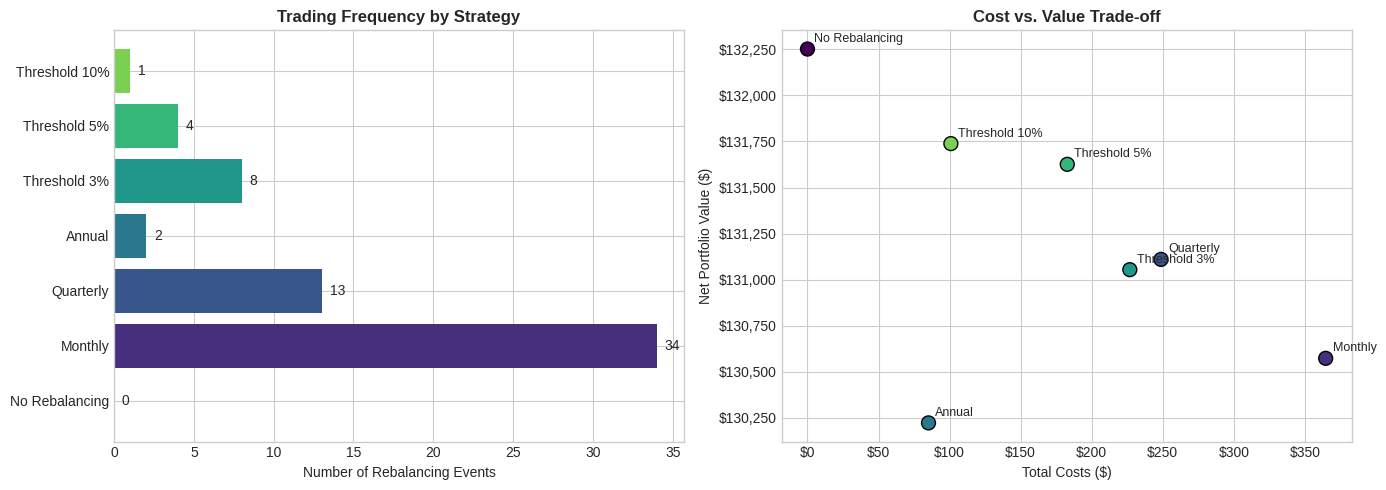

In [10]:
# Visualize the trade-off between trades and drift control
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Number of trades vs strategy
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 0.8, len(cost_analysis)))
bars = ax1.barh(cost_analysis['Strategy'], cost_analysis['Num_Trades'], color=colors)
ax1.set_xlabel('Number of Rebalancing Events')
ax1.set_title('Trading Frequency by Strategy', fontsize=12, fontweight='bold')

# Add value labels
for bar, val in zip(bars, cost_analysis['Num_Trades']):
    ax1.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{int(val)}',
             va='center', fontsize=10)

# Plot 2: Total costs vs final value
ax2 = axes[1]
scatter = ax2.scatter(cost_analysis['Total_Costs'],
                       cost_analysis['Net_Value'],
                       s=100, c=colors, edgecolors='black')

for i, row in cost_analysis.iterrows():
    ax2.annotate(row['Strategy'], (row['Total_Costs'], row['Net_Value']),
                 textcoords="offset points", xytext=(5, 5), fontsize=9)

ax2.set_xlabel('Total Costs ($)')
ax2.set_ylabel('Net Portfolio Value ($)')
ax2.set_title('Cost vs. Value Trade-off', fontsize=12, fontweight='bold')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '${:,.0f}'.format(y)))

plt.tight_layout()
plt.show()

---

## Part 4: Tax-Efficient Rebalancing

In taxable accounts, selling winners triggers capital gains taxes. Smart rebalancing minimizes this.

### Tax-Efficient Techniques

1. **Use new contributions**: Direct new money to underweight assets
2. **Rebalance with dividends**: Reinvest dividends in underweight assets
3. **Tax-loss harvesting**: Sell losers to offset gains
4. **Asset location**: Hold tax-inefficient assets in tax-advantaged accounts
5. **Charitable giving**: Donate appreciated shares instead of selling

In [11]:
def tax_efficient_rebalance(current_weights, target_weights, portfolio_value,
                            new_contribution=0, available_tax_loss=0):
    """
    Calculate tax-efficient rebalancing trades.

    Prioritizes:
    1. Using new contributions
    2. Selling assets with losses
    3. Selling assets with smallest gains

    Parameters:
    -----------
    current_weights : dict
        Current portfolio weights
    target_weights : dict
        Target weights
    portfolio_value : float
        Current portfolio value (before contribution)
    new_contribution : float
        New cash being added
    available_tax_loss : float
        Available tax losses to offset gains
    """
    total_value = portfolio_value + new_contribution

    # Calculate ideal trades
    ideal_trades = {}
    for ticker in target_weights:
        current_value = current_weights[ticker] * portfolio_value
        target_value = target_weights[ticker] * total_value
        ideal_trades[ticker] = target_value - current_value

    # First, allocate new contribution to underweight assets
    contribution_allocation = {}
    remaining_contribution = new_contribution

    # Sort by how underweight each asset is
    underweight = {t: max(0, ideal_trades[t]) for t in ideal_trades}
    total_underweight = sum(underweight.values())

    if total_underweight > 0 and new_contribution > 0:
        for ticker in underweight:
            if underweight[ticker] > 0:
                # Allocate proportionally to underweight
                allocation = min(
                    underweight[ticker],
                    new_contribution * (underweight[ticker] / total_underweight)
                )
                contribution_allocation[ticker] = allocation
                remaining_contribution -= allocation

    # Calculate remaining trades needed after contribution
    remaining_trades = {}
    for ticker in ideal_trades:
        contribution_used = contribution_allocation.get(ticker, 0)
        remaining_trades[ticker] = ideal_trades[ticker] - contribution_used

    return {
        'ideal_trades': ideal_trades,
        'contribution_allocation': contribution_allocation,
        'remaining_trades': remaining_trades,
        'contribution_absorbed': new_contribution - remaining_contribution,
        'remaining_contribution': remaining_contribution
    }


# Example: Portfolio drifted, adding $10,000 contribution
current = {'SPY': 0.70, 'BND': 0.30}  # Drifted from 60/40
target = {'SPY': 0.60, 'BND': 0.40}
portfolio_value = 100000
contribution = 10000

result = tax_efficient_rebalance(current, target, portfolio_value, contribution)

print("Tax-Efficient Rebalancing Example")
print("=" * 50)
print(f"Current portfolio: $100,000 (70% SPY, 30% BND)")
print(f"Target allocation: 60% SPY, 40% BND")
print(f"New contribution: $10,000")
print()
print("Without new contribution (taxable sales needed):")
for ticker, amount in result['ideal_trades'].items():
    action = "Buy" if amount > 0 else "Sell"
    print(f"  {ticker}: {action} ${abs(amount):,.2f}")

print()
print("With new contribution (tax-efficient):")
print(f"  Contribution allocation:")
for ticker, amount in result['contribution_allocation'].items():
    if amount > 0:
        print(f"    {ticker}: Buy ${amount:,.2f} (from contribution)")

print(f"\n  Remaining trades needed:")
for ticker, amount in result['remaining_trades'].items():
    if abs(amount) > 100:  # Only show significant trades
        action = "Buy" if amount > 0 else "Sell"
        print(f"    {ticker}: {action} ${abs(amount):,.2f}")

Tax-Efficient Rebalancing Example
Current portfolio: $100,000 (70% SPY, 30% BND)
Target allocation: 60% SPY, 40% BND
New contribution: $10,000

Without new contribution (taxable sales needed):
  SPY: Sell $4,000.00
  BND: Buy $14,000.00

With new contribution (tax-efficient):
  Contribution allocation:
    BND: Buy $10,000.00 (from contribution)

  Remaining trades needed:
    SPY: Sell $4,000.00
    BND: Buy $4,000.00


---

## Part 5: Complete Rebalancing System

Let's build a comprehensive rebalancing system that combines everything.

In [13]:
class PortfolioRebalancer:
    """
    A complete portfolio rebalancing system.

    Supports:
    - Multiple rebalancing strategies
    - Tax-efficient rebalancing
    - Transaction cost tracking
    - Rebalancing history
    """

    def __init__(self, target_weights, threshold=0.05,
                 transaction_cost_bps=5, min_trade_size=100):
        """
        Initialize the rebalancer.

        Parameters:
        -----------
        target_weights : dict
            Target allocation {'AAPL': 0.3, 'GOOGL': 0.3, 'BND': 0.4}
        threshold : float
            Rebalance when drift exceeds this (default 5%)
        transaction_cost_bps : float
            Transaction cost in basis points
        min_trade_size : float
            Minimum trade size (ignore smaller drifts)
        """
        self.target_weights = target_weights
        self.threshold = threshold
        self.transaction_cost_bps = transaction_cost_bps
        self.min_trade_size = min_trade_size
        self.history = []

        # Validate weights sum to 1
        total = sum(target_weights.values())
        if abs(total - 1.0) > 0.001:
            raise ValueError(f"Target weights must sum to 1.0, got {total}")

    def analyze_drift(self, current_values):
        """
        Analyze how far the portfolio has drifted from target.

        Parameters:
        -----------
        current_values : dict
            Current dollar values {'AAPL': 30000, 'GOOGL': 35000, 'BND': 35000}

        Returns:
        --------
        dict with drift analysis
        """
        total_value = sum(current_values.values())
        current_weights = {t: v / total_value for t, v in current_values.items()}

        drift = {}
        for ticker in self.target_weights:
            current = current_weights.get(ticker, 0)
            target = self.target_weights[ticker]
            drift[ticker] = {
                'current_weight': current,
                'target_weight': target,
                'drift': current - target,
                'drift_pct': (current - target) * 100,
                'within_threshold': abs(current - target) <= self.threshold
            }

        max_drift = max(abs(d['drift']) for d in drift.values())
        needs_rebalancing = max_drift > self.threshold

        return {
            'total_value': total_value,
            'current_weights': current_weights,
            'drift_by_asset': drift,
            'max_drift': max_drift,
            'needs_rebalancing': needs_rebalancing
        }

    def calculate_trades(self, current_values, new_contribution=0):
        """
        Calculate the trades needed to rebalance.

        Returns trades that respect minimum trade size.
        """
        total_value = sum(current_values.values()) + new_contribution

        trades = {}
        for ticker in self.target_weights:
            current_value = current_values.get(ticker, 0)
            target_value = self.target_weights[ticker] * total_value
            trade_amount = target_value - current_value

            # Only include if above minimum trade size
            if abs(trade_amount) >= self.min_trade_size:
                trades[ticker] = {
                    'current_value': current_value,
                    'target_value': target_value,
                    'trade_amount': trade_amount,
                    'action': 'BUY' if trade_amount > 0 else 'SELL'
                }

        # Calculate costs
        total_traded = sum(abs(t['trade_amount']) for t in trades.values()) / 2
        transaction_cost = total_traded * (self.transaction_cost_bps / 10000)

        return {
            'trades': trades,
            'total_traded': total_traded,
            'transaction_cost': transaction_cost,
            'new_contribution': new_contribution
        }

    def generate_report(self, current_values):
        """
        Generate a complete rebalancing report.
        """
        drift_analysis = self.analyze_drift(current_values)
        trade_plan = self.calculate_trades(current_values)

        report = []
        report.append("=" * 60)
        report.append("PORTFOLIO REBALANCING REPORT")
        report.append("=" * 60)
        report.append(f"\nTotal Portfolio Value: ${drift_analysis['total_value']:,.2f}")
        report.append(f"Rebalancing Threshold: {self.threshold:.0%}")
        report.append(f"Maximum Drift: {drift_analysis['max_drift']:.1%}")
        report.append(f"Rebalancing Needed: {'YES' if drift_analysis['needs_rebalancing'] else 'NO'}")

        report.append("\n" + "-" * 60)
        report.append("CURRENT vs TARGET ALLOCATION")
        report.append("-" * 60)
        report.append(f"{'Asset':<10} {'Current':>12} {'Target':>12} {'Drift':>12}")
        report.append("-" * 60)

        for ticker, data in drift_analysis['drift_by_asset'].items():
            status = "OK" if data['within_threshold'] else "REBAL"
            report.append(f"{ticker:<10} {data['current_weight']:>11.1%} {data['target_weight']:>11.1%} "
                         f"{data['drift_pct']:>+11.1f}%  {status}")

        if drift_analysis['needs_rebalancing']:
            report.append("\n" + "-" * 60)
            report.append("RECOMMENDED TRADES")
            report.append("-" * 60)

            for ticker, trade in trade_plan['trades'].items():
                report.append(f"{trade['action']:<6} {ticker:<10} ${abs(trade['trade_amount']):>12,.2f}")

            report.append("\n" + "-" * 60)
            report.append(f"Total Amount Traded: ${trade_plan['total_traded']:,.2f}")
            report.append(f"Estimated Transaction Cost: ${trade_plan['transaction_cost']:.2f}")

        report.append("\n" + "=" * 60)

        return "\n".join(report)


# Create a rebalancer for a 4-asset portfolio
target = {
    'SPY': 0.40,   # US Large Cap
    'QQQ': 0.20,   # US Tech
    'VEA': 0.15,   # International
    'BND': 0.25    # Bonds
}

rebalancer = PortfolioRebalancer(target, threshold=0.05)

# Simulate a drifted portfolio
current_values = {
    'SPY': 52000,   # Grew to 52%
    'QQQ': 25000,   # Grew to 25%
    'VEA': 10000,   # Shrunk to 10%
    'BND': 13000    # Shrunk to 13%
}

# Generate report
print(rebalancer.generate_report(current_values))

PORTFOLIO REBALANCING REPORT

Total Portfolio Value: $100,000.00
Rebalancing Threshold: 5%
Maximum Drift: 12.0%
Rebalancing Needed: YES

------------------------------------------------------------
CURRENT vs TARGET ALLOCATION
------------------------------------------------------------
Asset           Current       Target        Drift
------------------------------------------------------------
SPY              52.0%       40.0%       +12.0%  REBAL
QQQ              25.0%       20.0%        +5.0%  OK
VEA              10.0%       15.0%        -5.0%  OK
BND              13.0%       25.0%       -12.0%  REBAL

------------------------------------------------------------
RECOMMENDED TRADES
------------------------------------------------------------
SELL   SPY        $   12,000.00
SELL   QQQ        $    5,000.00
BUY    VEA        $    5,000.00
BUY    BND        $   12,000.00

------------------------------------------------------------
Total Amount Traded: $17,000.00
Estimated Transaction C

---

## Key Takeaways

### Rebalancing Fundamentals

1. **Drift is inevitable**: Asset returns differ, so weights change over time
2. **Rebalancing maintains risk profile**: Without it, your portfolio may become riskier than intended
3. **It's contrarian by design**: Sell winners, buy losers (which feels wrong but is mathematically sound)

### Strategy Selection

| Strategy | Best For | Drawback |
|----------|----------|----------|
| **Calendar (Quarterly)** | Simple, set-and-forget | May trade when unnecessary |
| **Threshold (5%)** | Cost-efficient | Requires monitoring |
| **Hybrid** | Balance of both | Slightly more complex |

### Cost Considerations

- Transaction costs are usually small (especially with $0 commissions)
- **Taxes are the bigger concern** in taxable accounts
- Use new contributions to rebalance tax-free when possible

### The 5% Rule

Research consistently finds that a **5% threshold** provides:
- Good drift control (keeps you near target)
- Reasonable trading frequency (not too often)
- Acceptable transaction costs

---

## Summary

Portfolio rebalancing is the discipline of maintaining your intended asset allocation. Without it, a 60/40 portfolio can drift to 70/30 or worse during bull markets, exposing you to more risk than planned.

**The practical approach for most investors:**

1. Set a **5% threshold** for each asset class
2. Check allocation **quarterly**
3. Only rebalance if threshold is breached
4. Use **new contributions** to rebalance when possible
5. In taxable accounts, prioritize **tax efficiency** over perfect weights

Rebalancing isn't about maximizing returns—it's about **maintaining your risk profile** so you can sleep at night and stick to your long-term plan.

---

*Next notebook: You now have the foundation to build AI agents that can automate these investment decisions.*